In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
import os
import numpy as np

import time
import numpy as np
import pandas as pd
import matplotlib
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
import scipy.stats as ss
from collections import defaultdict
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; 

In [4]:
np.random.seed(21)

In [5]:
sns.set()
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("tab10")

In [6]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'grid'])

In [7]:
os.chdir("..")

In [8]:
pwd

'/home/maksym/interlingua'

In [9]:
N=3000
with open(f"experiments/data_encoded{N}.pkl", 'rb') as f:
    hiddens_base = pickle.load(f)

In [10]:

def compute_sent_reps(hiddens):
    # hiddens: N x L x 1 x sen_len x emb_size
    for i, n in enumerate(hiddens):
        for j, l in enumerate(n):
            hiddens[i][j] = l.squeeze(0).mean(0)

In [11]:
for k, v in hiddens_base.items():
    compute_sent_reps(v)

In [12]:
len(hiddens_base['Europarl'])

3000

In [13]:
def transpose_pylists_dict(d):
    for k,v in d.items():
        d[k] = np.array(list(map(list, zip(*v))))
    return d

In [14]:
hiddens_base = transpose_pylists_dict(hiddens_base)

In [15]:
hiddens_base['Europarl'][2].shape

(3000, 512)

In [16]:
def prepare_reps(hiddens_dict):
    all_reps_prepared = defaultdict(lambda: list())
    all_labels = defaultdict(lambda: list())
    
    for dn, reps_all_layers in hiddens_dict.items():
        for layer_num, reps_layer in enumerate(reps_all_layers):
            all_reps_prepared[layer_num].extend(reps_layer)
            all_labels[layer_num].extend([dn] * len(reps_layer))
    
    for k, v in all_reps_prepared.items():
        all_reps_prepared[k] = np.array(v)
    
    for k, v in all_labels.items():
        all_labels[k] = np.array(v)
    
    return all_reps_prepared, all_labels

In [17]:
import warnings
warnings.filterwarnings('ignore')

# TSNE

In [18]:
def to_df(reps, labels):
    reps = pd.DataFrame(reps)
    reps['domain'] = labels
    return reps.sample(frac=1)

In [19]:
DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14

names = ['Base', 'Base-long'] + DOMAIN_NAMES
i = 0

all_reps_tsne = {}
all_labels_tsne = {}

for curr_all_hiddens in [hiddens_base]:
    print(f'processing {names[i]}')
    
    reps_tsne = []
    labels_tsne = []
    hiddens_reps, hiddens_labels = prepare_reps(curr_all_hiddens)
    
    for l in range(NUM_LAYERS):

        indices = np.arange(hiddens_reps[l].shape[0])
        np.random.shuffle(indices)

        hiddens_shuff = hiddens_reps[l][indices][0:]
        labels_shuff = hiddens_labels[l][indices]

        hiddens_tsne = TSNE(
            n_components=2, 
            verbose=0, 
            n_jobs=-1, 
            metric='cosine', 
            perplexity=30, 
            init='random').fit_transform(hiddens_shuff)

        reps_tsne.append(hiddens_tsne)
        labels_tsne.append(labels_shuff)
        
    all_reps_tsne[names[i]] = reps_tsne
    all_labels_tsne[names[i]] = labels_tsne
    
    i += 1
    print()

processing Base



In [24]:

sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

k="Base"
reps_tsne = all_reps_tsne[k]
labels = all_labels_tsne[k]

fig, axs = plt.subplots(1, NUM_LAYERS, figsize=(20,2.5))

for num_layer in range(NUM_LAYERS):
    
    df = to_df(reps_tsne[num_layer], labels[num_layer]).sample(frac=1)
    
    sns.scatterplot(ax = axs[num_layer], x=df[0], y=df[1],
                    hue=df['domain'], hue_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"], 
                    s=70, style=df['domain'], style_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"])


#     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
#        .map(plt.scatter, 0, 1) \
#        .add_legend()
    
    axs[num_layer].set_xticklabels(" ")
    axs[num_layer].set_yticklabels(" ")
    axs[num_layer].set_xlabel(f"L {num_layer}")
    axs[num_layer].set_ylabel(" ")    
    axs[num_layer].legend().set_visible(False)

    #if num_layer == 0:
    #    pass
        #axs[ind].legend().set_visible(True)
        #axs[ind].legend
        #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
#axs[num_layer].set_title(f"T-SNE for {k} tuned model")
handles, ax_labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=3, bbox_to_anchor=(0.5, 1.39))
fig.suptitle(f"t-SNE for {k} model", y=1.05)
fig.savefig("assets/multidomain/tsne_concat60.pdf", bbox_inches='tight')

# PCA

In [21]:
DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14

names = ['Base', 'Base-long'] + DOMAIN_NAMES
i = 0

all_reps_pca = {}
all_labels_pca = {}

for curr_all_hiddens in [hiddens_base]:
    print(f'processing {names[i]}')
    
    reps_pca = []
    labels_pca = []
    hiddens_reps, hiddens_labels = prepare_reps(curr_all_hiddens)
    
    for l in range(NUM_LAYERS):

        indices = np.arange(hiddens_reps[l].shape[0])
        np.random.shuffle(indices)

        hiddens_shuff = hiddens_reps[l][indices][0:]
        labels_shuff = hiddens_labels[l][indices]

        hiddens_pca = PCA(
            n_components=2, 
            random_state=0,
            ).fit_transform(hiddens_shuff)

        reps_pca.append(hiddens_pca)
        labels_pca.append(labels_shuff)
        
    all_reps_pca[names[i]] = reps_pca
    all_labels_pca[names[i]] = labels_pca
    
    i += 1
    print()

processing Base



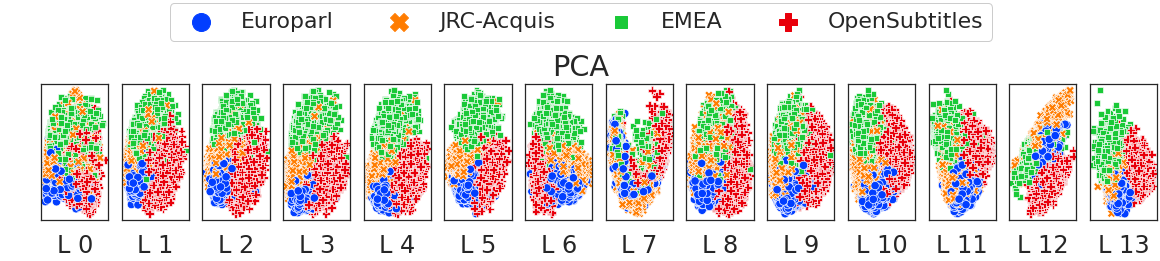

In [23]:

sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

k="Base"
reps_pca = all_reps_pca[k]
labels = all_labels_pca[k]

fig, axs = plt.subplots(1, NUM_LAYERS, figsize=(20,2.5))

for num_layer in range(NUM_LAYERS):
    
    df = to_df(reps_pca[num_layer], labels[num_layer]).sample(frac=1)
    
    sns.scatterplot(ax = axs[num_layer], x=df[0], y=df[1],
                    hue=df['domain'], hue_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"], 
                    s=70, style=df['domain'], style_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"])


#     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
#        .map(plt.scatter, 0, 1) \
#        .add_legend()
    
    axs[num_layer].set_xticklabels(" ")
    axs[num_layer].set_yticklabels(" ")
    axs[num_layer].set_xlabel(f"L {num_layer}")
    axs[num_layer].set_ylabel(" ")    
    axs[num_layer].legend().set_visible(False)

    #if num_layer == 0:
    #    pass
        #axs[ind].legend().set_visible(True)
        #axs[ind].legend
        #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
#axs[num_layer].set_title(f"T-SNE for {k} tuned model")
handles, ax_labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=3, bbox_to_anchor=(0.5, 1.39))
fig.suptitle(f"PCA", y=1.05)
fig.savefig("assets/multidomain/pca_concat60.pdf", bbox_inches='tight')